In [1]:
# pip install opencv-python

In [1]:
# sys.path.append('../../')
import fastmri
from fastmri.data import transforms as T 

In [2]:
# %matplotlib inline
import sys
import h5py
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image, ImageEnhance
from matplotlib import pyplot as plt
from pathlib import Path
import cv2

In [3]:
# Import dataset
file_path = Path('singlecoil_train')
file_list = list(file_path.glob('**/*.h5'))

In [4]:
# list(file_path.glob('**/*.h5'))

In [5]:
# Choose .h5 file
file_name = file_list[2]
hf = h5py.File(file_name,'r')

In [6]:
file_name = str(file_name)

In [7]:
SliceDataset = fastmri.data.mri_data.SliceDataset(file_path,"singlecoil","knee","all")

In [8]:
# SliceDataset.raw_samples

In [9]:
annotatedSliceDataset = fastmri.data.mri_data.AnnotatedSliceDataset(file_path,"singlecoil","knee","all", annotation_version="640500fb")

In [146]:
file_name = "file1000003.h5"
file_name = "singlecoil_train/"+file_name

In [153]:
# Choose slice
slice_choice = 23
# df = pd.DataFrame(annotatedSliceDataset.raw_samples)
# labels_for_slice = df[(df['fname'] == "singlecoil_train/" + file_name) & (df['slice_ind'] == slice_choice)]['metadata'].values.tolist()
# labels_for_slice = df[(df['fname'] == "singlecoil_train/" + file_name)]['metadata'].values.tolist()
# labels_for_slice = df[(df['fname'] == file_name) & (df['slice_ind'] > 0)]['metadata'].values.tolist()
# labels_for_slice

In [156]:
raw_samples = annotatedSliceDataset.raw_samples
labels_for_slice = [
            sample.metadata for sample in raw_samples
            if str(sample.fname) == file_name and sample.metadata['annotation']['x'] > 0 
            # and sample.slice_ind == slice_choice
        ]

In [167]:
unique_labels = []
all_diagnosis = []
for single_label in labels_for_slice:
    diagnosis = single_label['annotation']['label']
    if diagnosis not in all_diagnosis:
        all_diagnosis.append(diagnosis)
        unique_labels.append(single_label)
# print(all_diagnosis)
# print(unique_labels)

Plot bounding box for annotation-change method
The bounding box need to move up one pixel to match

In [168]:
def plot_bounding_box(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white") 
    plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
  return np.array(image)

In [169]:
img_data = hf['reconstruction_rss'][:]
img_data.shape

(45, 320, 320)

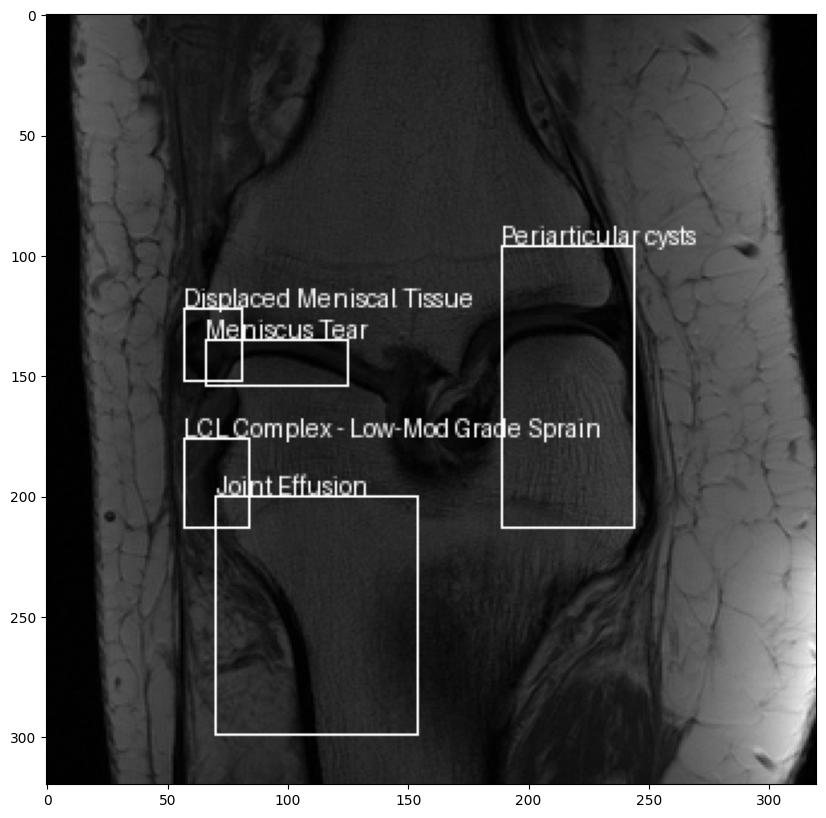

In [170]:
# Display an imageslice with annotations
arrimg = np.squeeze(img_data[slice_choice,:,:])
image_2d_scaled = (np.maximum(arrimg,0) / arrimg.max()) * 255.0
image_2d_scaled = Image.fromarray(np.uint8(image_2d_scaled))
annotated_img = plot_bounding_box(image_2d_scaled, unique_labels)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img,'gray')
plt.show()

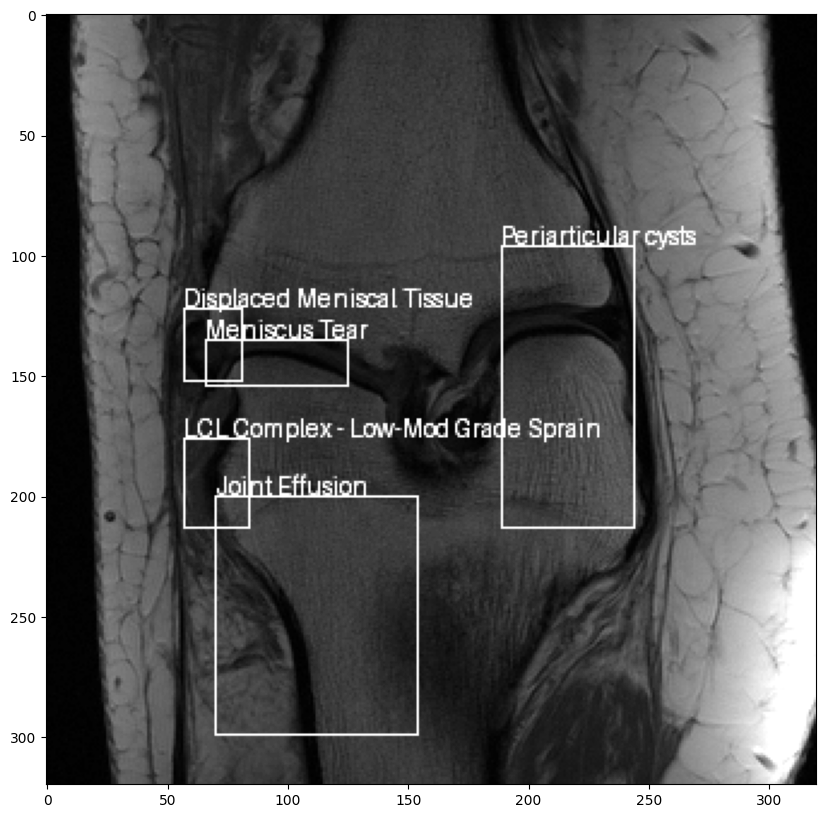

In [190]:
enhancer = ImageEnhance.Brightness(Image.fromarray(annotated_img))
annotated_img_enhanced = enhancer.enhance(1.5)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img_enhanced,'gray')
plt.savefig("multiple_bounding_boxes_sample.png")
plt.show()

In [172]:
# Zoomed image focusing on the tear
def plot_zoom_in_bounding_box(image, labels):
  plotted_image = ImageDraw.Draw(image)
  for label in labels:
    _, _, _, x0, y0, w, h, label_txt = label['annotation'].values()
    x1 = x0 + w
    y1 = y0 + h
    plotted_image.rectangle(((x0,y0), (x1,y1)), outline="white") 
    plotted_image.text((x0, max(0, y0 - 10)), label_txt, fill= "white")
    
  return np.array(image)

In [173]:
def cv2_clipped_zoom(img, zoom_factor=0):

    if zoom_factor == 0:
        return img

    height, width = img.shape[:2] # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(np.int32)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

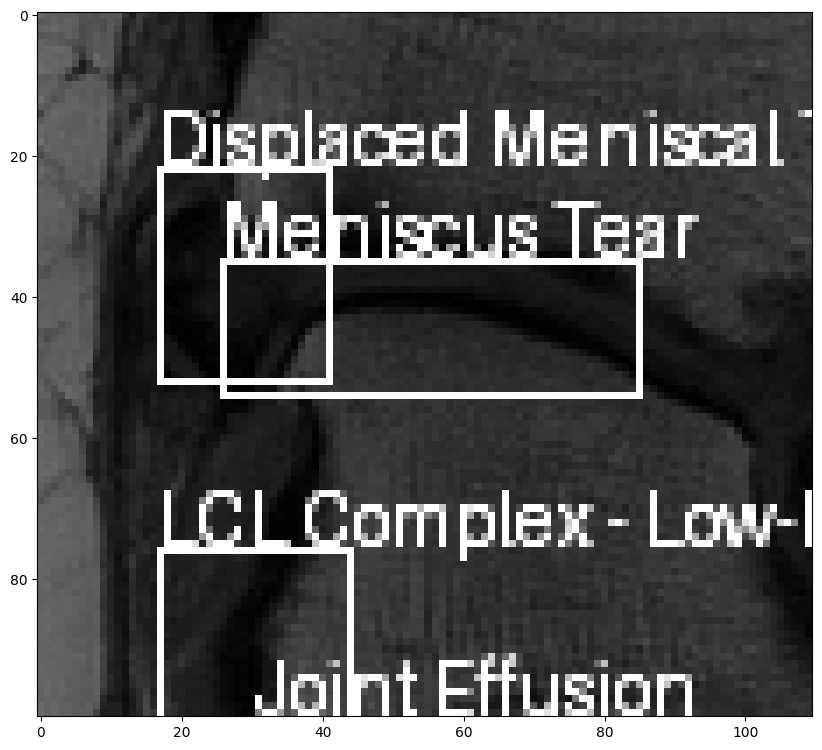

In [189]:
annotated_img_zoom_in = cv2_clipped_zoom(np.array(annotated_img_enhanced)[100:200,40:150],1)
plt.figure(figsize = (10,10))
plt.imshow(annotated_img_zoom_in,'gray')
plt.savefig("multiple_bounding_boxes_zoom.png")
plt.show()